# 1. Computer-controlled systems

## Sampled-data control
![CCSp2](pics/CCSp2_f1_1.jpg)

## Modern industrial control (Industry 4.0 / Smart Industry)
![CCSp9](pics/CCSp9_f1_3.jpg)

## Effects of sampling
![CCSp12](pics/CCSp12_f1_4.jpg)

## Example 1.2 Controlling the arm of a disk drive
Disk-drive assembly with $J$ moment of inertia and $k$ the motor constant:

Torque:                $m(t)~ = ~k u(t)$
Angular-acceleration:  $\alpha(t) ~=~\frac{1}{J}m(t)$ 

Oefening: bepaal DV van systeem met ingang $u(t)$ en uitgang $\theta(t)$ (hoek) en bepaal overbrengingsfunctie.

Oplossing:
DV:
$$J\ddot{\theta}(t)~=~ ku(t)$$
Overbrengingsfunctie:
$$\frac{\Theta(s)}{U(s)}~=~\frac{k}{Js^2}$$

## Example 1.2 Controlling the arm of a disk drive
Disk-drive assembly with $J$ moment of inertia and $k$ the motor constant:
$$ G(s) ~= ~ \frac{k}{Js^2} $$
Servo control law:
$$ U(s) ~= ~ \frac{bK}{a} U_c(s) - K \frac{s+b}{s+a}Y(s) $$
Choose control parameters:
$$ a=2\omega_0, ~~~~ b = \omega_0/2,~~~~ K=2\frac{J\omega_0^2}{k}$$

In [1]:
import numpy as np
from matplotlib import pylab as plt
import control as ctrl
%matplotlib inline

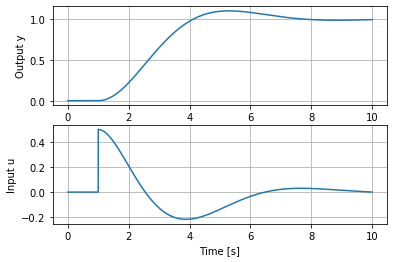

In [2]:
%matplotlib inline
k = 1.0
J = 1.0

G = ctrl.tf(k,[J,0.,0.])
omega_0 = 1.0
a = 2*omega_0
b = omega_0/2
K = 2*J*omega_0**2/k 
C = ctrl.tf([1,b],[1,a])
Gcl_y = (K*b/a)*ctrl.feedback(G,K*C)
Gcl_u = (K*b/a)*ctrl.feedback(1,G*K*C)

t_cont = np.linspace(0,10,10000)
uc = 0*t_cont; uc[t_cont>1] = 1
_,y_cont,_ = ctrl.forced_response(Gcl_y,t_cont,uc)
_,u_cont,_ = ctrl.forced_response(Gcl_u,t_cont,uc)
plt.subplot(211)
plt.plot(t_cont,y_cont)
plt.ylabel('Output y'); plt.grid()
plt.subplot(212)
plt.plot(t_cont,u_cont)
plt.ylabel('Input u'); plt.xlabel('Time [s]'); plt.grid()

<IPython.core.display.Javascript object>


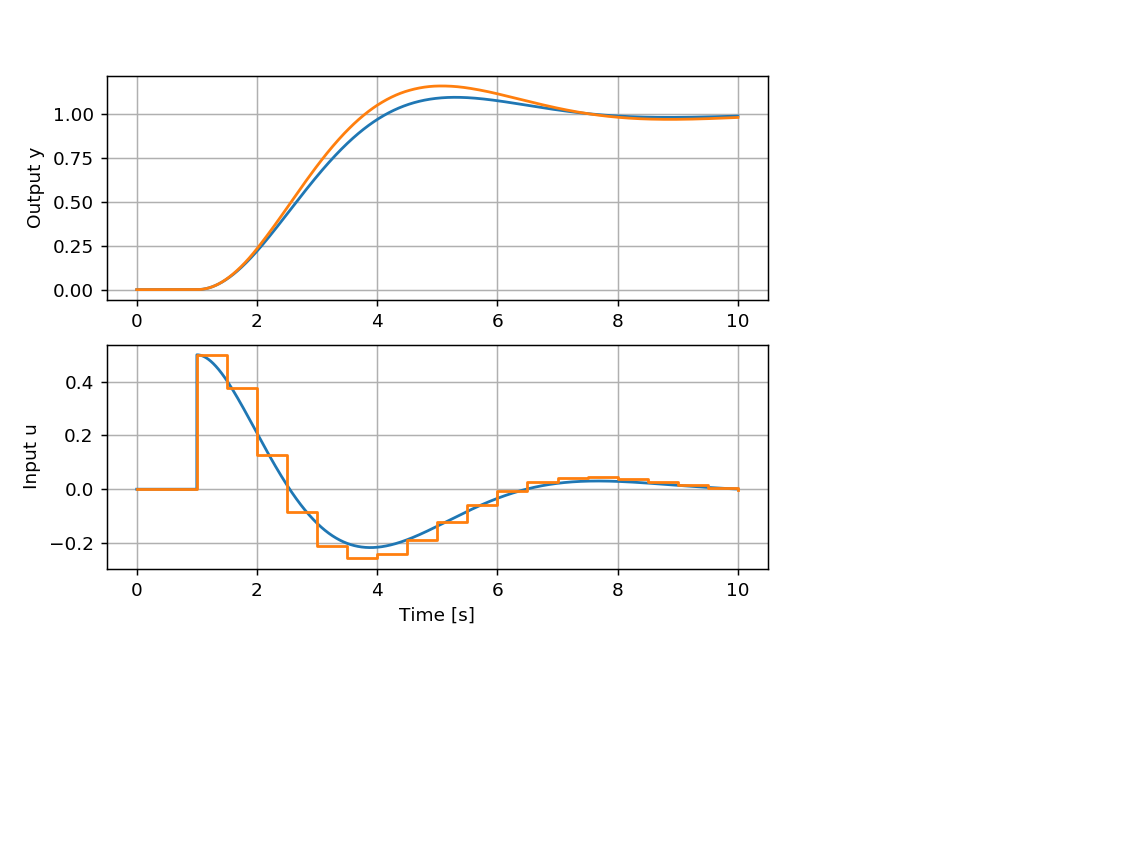

In [9]:
%matplotlib notebook
h = .5# alleen waarden die >= t[1]-t[0] zijn invoeren
x = np.zeros((1))
u = np.zeros((0))
index = np.zeros((0),dtype=np.uint)

y_discr = 0*y_cont
state_init = np.zeros((2))
k = 0
while True:
    index = np.append(index,np.uint(np.argmin(np.abs(t_cont-k*h))))
    # simulate continuous system from tc[index[k-1]] until tc[index[k]]
    if k>0: # wait one step, so index[k-1] can be evaluated
        _,y_discr[np.uint(index[k-1]+1):np.uint(index[k]+1)],states = ctrl.forced_response(G,t_cont[np.uint(index[k-1]+1):np.uint(index[k]+1)],u[k-1]*np.ones((index[k]-index[k-1])),state_init)
        state_init = states[:,-1] # remember state for next step
    # discrete time controller:
    u = np.append(u,K*((b/a)*uc[index[k]]-y_discr[index[k]]+x[k]))
    x = np.append(x,x[k]+h*((a-b)*y_discr[index[k]]-a*x[k]))
    k += 1
    if k*h>t_cont[-1]:
        break
        
plt.subplot(211)
plt.plot(t_cont,y_cont)
plt.plot(t_cont,y_discr)
plt.ylabel('Output y'); plt.grid()
plt.subplot(212)
plt.plot(t_cont,u_cont)
plt.step(t_cont[index],u,where='post')
plt.ylabel('Input u'); plt.xlabel('Time [s]'); plt.grid()

## Deadbeat control:

<IPython.core.display.Javascript object>


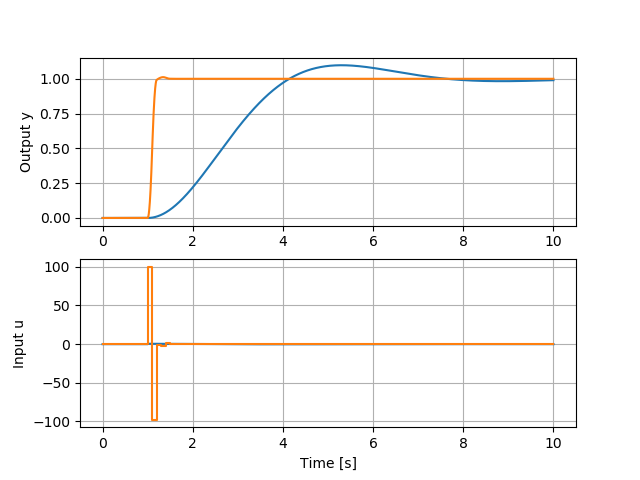

In [4]:
# deadbeat controller parameters
%matplotlib notebook

h = .1
s0=2.5/(h*h);                                                                                                                                                               
s1=-1.5/(h*h);                                                                                                                                                              
r1=0.75;                                                                                                                                                                    
t0=1/(h*h);                                                                                                                                                                 
t1=0; 

k = 0
x = np.zeros((1))
u = np.zeros((0))
index = np.zeros((0),dtype=np.uint)

y_discr = 0*y_cont
state_init = np.zeros((2))
k = 0
while True:
    index = np.append(index,np.uint(np.argmin(np.abs(t_cont-k*h))))
    # simulate continuous system from tc[index[k-1]] until tc[index[k]]
    if k>0: # wait one step, so index[k-1] can be evaluated
        _,y_discr[np.uint(index[k-1]+1):np.uint(index[k]+1)],states = ctrl.forced_response(G,t_cont[np.uint(index[k-1]+1):np.uint(index[k]+1)],u[k-1]*np.ones((index[k]-index[k-1])),state_init)
        state_init = states[:,-1] # remember state for next step
    # discrete time controller:
    if k==0:
        u = np.append(u,0.0)
    else:
        unew = t0*uc[index[k]] + t1*uc[index[k-1]] - s0*y_discr[index[k]] - s1*y_discr[index[k-1]] -r1*u[k-1]
        u = np.append(u,unew)
    k += 1
    if k*h>t_cont[-1]:
        break
        
plt.subplot(211)
plt.plot(t_cont,y_cont)
plt.plot(t_cont,y_discr)
plt.ylabel('Output y'); plt.grid()
plt.subplot(212)
plt.plot(t_cont,u_cont)
plt.step(t_cont[index],u,where='post')
plt.ylabel('Input u'); plt.xlabel('Time [s]'); plt.grid()

## 2. Bemonsteren, reconstructie en aliasing


<IPython.core.display.Javascript object>


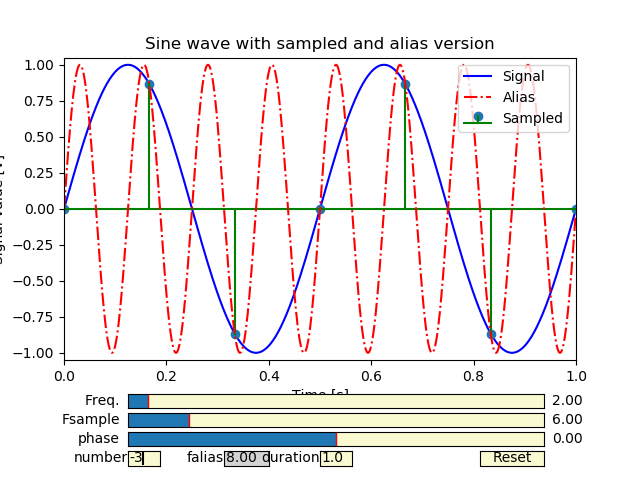

In [18]:
# Author:  Rufus Fraanje
# Email:   p.r.fraanje@hhs.nl
# Licence: GNU General Public License (GNU GPLv3)
# Creation date: 2019-03-07
# Last modified: 2019-03-12

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, TextBox, Button
#%matplotlib qt

def calc_plot_data(duration,f,phase,fsample,number):

    def calc_alias(f,phase,fsample,number,t):
        #adjust this function:
        x_alias = 0*t
        f_alias = 0
        return x_alias,f_alias

    tc = np.arange(0,duration,2/f*1/1000.)  # continuous time, 2 periods 1000 samples
    xc = np.sin(2*np.pi*f*tc + phase) # (approximated) continuous time signal
    td = np.arange(0,duration,1/fsample)    # time axis of samples
    xd = np.sin(2*np.pi*f*td + phase) # sampled signal
    xalias,falias = calc_alias(f,phase,fsample,number,tc)

    return tc,xc,td,xd,xalias,falias


f = 2.  # frequency of signal in Hz
phase = 0*np.pi/4 # phase of signal in radians
fsample = 6.   # sampling rate in Hz
number = 0 # number of alias
duration = 1. # simulation time

tc,xc,td,xd,xalias,falias = calc_plot_data(duration,f,phase,fsample,number)


fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1,bottom=0.25)
ax.plot(tc,xc,'b',label=f'Signal')
ax.stem(td,xd,linefmt='g-',basefmt='g-',label='Sampled')
ax.plot(tc,xalias,'r-.',label=f'Alias')
ax.set_title(f'Sine wave with sampled and alias version')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal value [V]')
ax.legend(loc='upper right')
ax.axis([0,duration,-1.05,1.05])


axcolor='lightgoldenrodyellow'
axf       = plt.axes([0.2,0.15,0.65,0.03],facecolor=axcolor)
axfsample = plt.axes([0.2,0.11,0.65,0.03],facecolor=axcolor)
axphase = plt.axes([0.2,0.07,0.65,0.03],facecolor=axcolor)
axnumber   = plt.axes([0.2,0.03,0.05,0.03],facecolor=axcolor)
axfalias = plt.axes([0.35,0.03,0.07,0.03],facecolor=axcolor)
axduration = plt.axes([0.5,0.03,0.05,0.03],facecolor=axcolor)

sf       = Slider(axf,'Freq.',0.1,40,valinit=f,valstep=0.1)
sfsample = Slider(axfsample,'Fsample',0.2,40,valinit=fsample,valstep=0.2)
sphase = Slider(axphase,'phase',-3,3,valinit=phase,valstep=0.1)
tnumber = TextBox(axnumber,'number',initial=str(number),color=axcolor,hovercolor='0.975')
tduration = TextBox(axduration,'duration',initial=str(duration),color=axcolor,hovercolor='0.975')
tfalias = TextBox(axfalias,'falias',initial=f'{falias:.2f}',color='lightgray',hovercolor='lightgray')

def update_plot(val):
    f = sf.val
    fsample = sfsample.val
    phase = sphase.val
    number = float(tnumber.text)
    print(f"number = {number}")
    duration = float(tduration.text)
    tc,xc,td,xd,xalias,falias = calc_plot_data(duration,f,phase,fsample,number)
    tfalias.set_val(f'{falias:.2f}')
    tfalias.stop_typing() # remove cursor

    ax.cla()
    ax.plot(tc,xc,'b',label=f'Signal')
    ax.stem(td,xd,linefmt='g-',basefmt='g-',label='Sampled')
    ax.plot(tc,xalias,'r-.',label=f'Alias')
    ax.set_title(f'Sine wave with sampled and alias version')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Signal value [V]')
    ax.legend(loc='upper right')
    ax.axis([0,duration,-1.05,1.05])

    fig.canvas.draw_idle()

    return True

sf.on_changed(update_plot)
sfsample.on_changed(update_plot)
sphase.on_changed(update_plot)

tnumber.on_submit(update_plot)
tduration.on_submit(update_plot)
tfalias.stop_typing() # remove cursor

axreset = plt.axes([0.75, 0.03, 0.1, 0.03])
button = Button(axreset, 'Reset', color=axcolor, hovercolor='0.975')

def reset(event):
    sf.reset()
    sfsample.reset()
    sphase.reset()
    tnumber.set_val(str(number))
    tduration.set_val(str(duration))
    return True

button.on_clicked(reset)

plt.show();

f_sample =  20.0


<IPython.core.display.Javascript object>


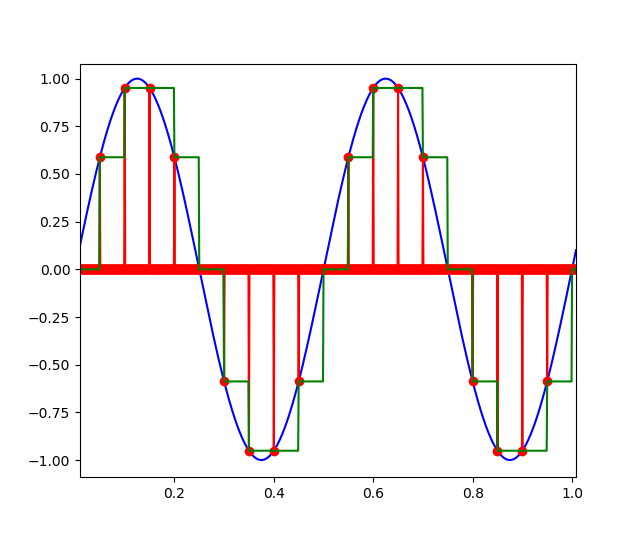

In [22]:
%matplotlib notebook
f  = 2 # Hz
fs_high = 1e3 # Hz

resample_factor = 50  # dus 
f_sample  = fs_high/resample_factor
print("f_sample = ",f_sample)

t = np.arange(0,10,1/fs_high)
N = t.shape[-1]
Nhalf = np.uint(np.ceil(N/2))
y = np.sin(2*np.pi*f*t)

y_pulse = np.kron(y[0::resample_factor],np.hstack((np.array([1]),np.zeros((resample_factor-1)))))
y_zoh = np.repeat(y[0::resample_factor],resample_factor)

plt.plot(t,y,'b')
plt.plot(t,y_pulse,'ro-')
plt.plot(t,y_zoh,'g')



<IPython.core.display.Javascript object>


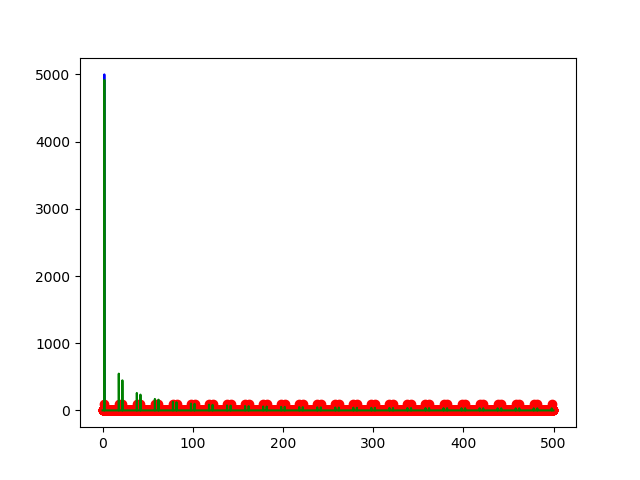

In [7]:
%matplotlib notebook
Y = np.fft.fft(y)
Y_pulse = np.fft.fft(y_pulse)
Y_zoh = np.fft.fft(y_zoh)
freq = np.fft.fftfreq(N)*fs_high
plt.plot(freq[:Nhalf],abs(Y[:Nhalf]),'b')
plt.plot(freq[:Nhalf],abs(Y_pulse[:Nhalf]),'ro-')
plt.plot(freq[:Nhalf],abs(Y_zoh[:Nhalf]),'g')

## 3. State-space modellen (toestandsruimte modelen)
(Zie ook: [Wikipedia: State-space representation (!)](https://en.wikipedia.org/wiki/State-space_representation))

State-space model beschrijving:

Continue tijd:
\begin{align}
\dot{x}(t) & = Ax(t) + B u(t)\\
y(t) &= Cx(t) + D u(t)
\end{align}

Discrete tijd:
\begin{align}
x_{k+1} & = Ax_k + B u_k\\
y_k &= Cx_k + D u_k
\end{align}



In [8]:
%load_ext itikz

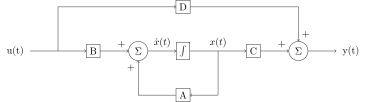

In [2]:
%%itikz --temp-dir --file-prefix mbrtc1-tikz- --implicit-pic --tex-packages=tikz --tikz-libraries=arrows,positioning
\node [circle] (u) {u(t)};
\coordinate [right=of u] (dot1) {}; 
\node [rectangle,draw,right=of dot1] (B) {B};
\node [circle,draw,right=of B] (sum1) {$\Sigma$}; 
\node [rectangle,draw,right=of sum1] (integ) {$\int$}; 
\coordinate [right=of integ] (dot2) {}; 
\node [rectangle,draw,below=of integ] (A) {A};
\node [rectangle,draw,right=of dot2] (C) {C};
\node [rectangle,draw,above=of integ] (D) {D};
\node [circle,draw,right=of C] (sum2) {$\Sigma$}; 
\node [circle,right=of sum2] (y) {y(t)};
 
\draw[->] (u) -- (B);
\draw[->] (dot1) |- (D);
\draw[->] (D) -| (sum2) node[pos=0.9,anchor=west] {+};
\draw[->] (B) -- (sum1) node[near end,anchor=south] {+};
\draw[->] (sum1) -- (integ) node[midway,anchor=south] {$\dot{x}(t)$};
\draw[->] (integ) -- (C)  node[midway,anchor=south] {${x}(t)$};
\draw[->] (dot2) |- (A);
\draw[->] (A) -| (sum1) node[pos=0.9,anchor=east] {+};
\draw[->] (C) -- (sum2) node[near end,anchor=south] {+};
\draw[->] (sum2) -- (y); 


## 4. Overzicht en leerdoelen
- wk 1: Inleiding computer-control theory, aliasing en state-space modellen
- wk 2: zoh-sampling van state-space modellen en andere transformaties
- wk 3: Input-output modellen (overbrengingsfuncties) en state-space modellen, polen en nulpunten
- wk 4: Systeem eigenschappen: stabiliteit, controllability, reachability en observability
- wk 5: State-feedback regelingen
- wk 6: State-observers en output feedback
- wk 7: Servo-control

<figure class="image">
<img src="pics/mbrtc_leerdoelen.png">
<!-- <figcaption>Fig. 1.1: Schematic diagram of a computer controlled system.</figcaption> -->
 </figure>

## Boek:
Karl J. Åström and Björn Wittenmark, Computer-Controlled Systems – Theory and Design, 3rd edition, Dover, 2011, ISBN-13: 978-0-486-48613-0, ISBN-10: 0-486-48613-3

## 5. Huiswerk week 1
(zie studiewijzer!)

- Bestuderen:
  - CCS Hst 1 (§1.2 aangeraden maar geen tentamenstof; §1.5 alleen verrijking, geen tentamenstof)
  - Bijlage A (zero-order hold discretisatie stappen komen in college 2 aan bod, nu alleen lezen)
  - Slides(!)
  - Zo nodig: ophalen matrix rekenen ([matrix-vector en matrix-matrix vermenigvuldiging](https://www.mathsisfun.com/algebra/matrix-multiplying.html), [inverse matrix](https://nl.wikipedia.org/wiki/Inverse_matrix), [determinant](https://nl.wikipedia.org/wiki/Determinant), [eigenwaarden en eigenvectoren](https://www.hhofstede.nl/modules/eigenwaarde.htm), [karakteristieke vergelijking](https://nl.wikipedia.org/wiki/Karakteristieke_polynoom))

- Oefeningen:
  1. Voor een reëel getal $a$, los de volgende DV voor $x(t)$ op voor $t\geq 0$:
    $$\dot{x} + a x = -1,~~~x(0)=1$$
  2. Reken de determinant uit van de matrix $\begin{bmatrix}5 & -2 \\ -2 & 8\end{bmatrix}$.
  3. Bereken de inverse van de matrix $\begin{bmatrix}8 & 2 \\ 2 & 5\end{bmatrix}$.
  4. Bereken de eigenwaarden van de matrix:
    1. $$A = \begin{bmatrix}0 & 1 \\ 1 & 0\end{bmatrix}$$
    2. $$A = \begin{bmatrix}0 & 1 \\ -1 & 0\end{bmatrix}$$
    3. $$A = \begin{bmatrix}0 & 1 \\ -25 & -6\end{bmatrix}$$
  5. Bestudeer de numpy-functie `np.linalg.eig` en controlleer met deze functie de uitkomsten bij 4.

- Oefeningen (vervolg):<br />
&nbsp;&nbsp; 6) De Fibonacci getallen zijn de getallen in de rij, beginnend met 0 en 1, en vervolgens is het volgende getal in de reeks de som van de twee voorafgaande: $0, 1, 1, 2, 3, 5, 8, \cdots$. Construeer een state-space model zonder ingang $u$:
  \begin{align}
  x_{k+1} & = ~ A x_k\\
  y_k & = C x_k
  \end{align}
  en begin-toestand $x_0$ zodat $y_k$ het $k^e$ Fibonacci getal levert. Optie: maak een python programma om dit systeem te simuleren.<br />
  &nbsp;&nbsp; 7) Een discrete-tijd systeem met ingang $u(k)$ en uitgang $y(k)$ wordt beschreven door de volgende differentie-vergelijking:
  $$
  y(k) + 0.5 y(k-1) ~ = ~ u(k)
  $$
  Bereken $y(k)$ voor $k=0,1,2,\cdots$ gegeven $y(-1)=0$ en $u(0)=1$ en $u(k)=0$ voor $k\geq 1$ (ofwel de ingang is een impulse en de uitgang is de impulse-responsie van het systeem in discrete tijd).
- Bestudeer en maak practicum opdracht 1